In [2]:
%matplotlib inline

import pickle
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import os

dataset = pd.read_csv('dataAccelGyroX1.txt')
dataset.head()

,Att 1,Att 2,Att 3,Att 4,Att 5,Att 6,Att 7,Att 8,Att 9,Att 10,...,Att 172,Att 173,Att 174,Att 175,Att 176,Att 177,Att 178,Att 179,Att 180,Action
0,-5700,6888,12384,420,-5707,-1692,-5980,6384,12776,794,...,1594,-8823,-4679,-2184,14992,1132,1294,-4062,-1328,0
1,-5980,6384,12776,794,-1036,-1222,-7348,7424,13836,730,...,1294,-4062,-1328,-1380,18304,1952,-906,-2616,1565,0
2,-7348,7424,13836,730,-2235,389,-5584,6744,13868,109,...,-906,-2616,1565,-1512,16124,2680,-753,2345,2680,0
3,-5584,6744,13868,109,-2177,-1112,-6224,6480,14060,-137,...,-753,2345,2680,-1576,14240,1920,-1713,550,3010,0
4,-6224,6480,14060,-137,1387,593,-6492,6288,13244,941,...,-1713,550,3010,-932,14812,2484,-1549,989,1968,0


In [3]:
# Spliting the points and the labels
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [9]:
window = 30 # depends on time window
epochs = 15
batch_size = 128
acc_vec_dim = 6 # depends on how many sensors used

class_names = list(set(y))
num_class = len(class_names)

X_testg = X_test.reshape(X_test.shape[0], acc_vec_dim, window)
X_traing = X_train.reshape(X_train.shape[0], acc_vec_dim, window)
print(X_testg.shape)
print(X_testg[0])

(17866, 6, 30)


In [11]:
model = Sequential()
model.add(LSTM(512,dropout=0.15,recurrent_dropout=0.15,input_shape=(acc_vec_dim, window)))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))
print(model.summary())

checkpoint_path = "trainingAG_LSTM/cp.ckpt" #MAKE SURE CHECK SINI DULU............................
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#model.load_weights(checkpoint_path)

history = model.fit(X_traing, y_train,
                        batch_size=batch_size,
                        epochs=15,
                        verbose=1,
                        validation_data=(X_testg, y_test),
                        callbacks=[cp_callback])

W0729 00:05:24.631557  5532 recurrent_v2.py:1098] Layer lstm_3 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 512)               1112064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                

In [12]:
preds = model.predict(X_testg)
predsList = preds.tolist()
predo = []
for valList in predsList:
    predo.append(valList.index(max(valList)))
predo = np.asarray(predo)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, predo)
print(conf_matrix)

class_report = classification_report(y_test, predo)
print(class_report)

[[6698  132  337]
 [ 139 7070  117]
 [ 468  312 2593]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7167
           1       0.94      0.97      0.95      7326
           2       0.85      0.77      0.81      3373

    accuracy                           0.92     17866
   macro avg       0.90      0.89      0.90     17866
weighted avg       0.91      0.92      0.91     17866



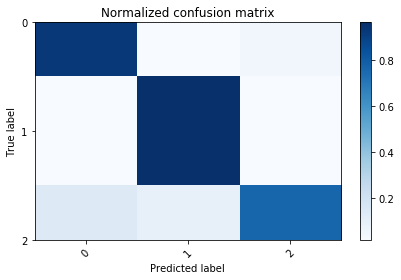

Classes:  [0, 1, 2]


In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(conf_matrix, classes=sorted(class_names), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('Classes: ', sorted(class_names))